In [4]:
#importing all required libraries and modules
import numpy as np
import pandas as pd
import os
import keras
from keras.utils.all_utils import Sequence

from collections import Counter, defaultdict
from pathlib import Path
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!nvidia-smi

Tue Jun 21 15:30:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Let us check the content of the dataset folder**

In [6]:
print(os.listdir("/content/drive/MyDrive/Dataset"))

['sample_submission.csv', 'test_images', 'train_images', 'train.csv']


Defining train and test dataframe directory

In [7]:
df_dirname = "/content/drive/MyDrive/Dataset"

train_df = pd.read_csv("/content/drive/MyDrive/Dataset/train.csv/train.csv") 
sample_df = pd.read_csv( os.path.join(df_dirname, "sample_submission.csv") )

In [8]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [9]:
sample_df.head()

,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


Let's see if there is any duplicate images in train and and sample data frame

In [10]:
print(train_df["ImageId"].duplicated().any())
print(sample_df["ImageId"].duplicated().any())

True
False


**Conclusion**

So, from above output it is clear that there is few duplicated images file in train_df and no duplicate/s exist in sample_df

In [11]:
print(train_df["ClassId"].isnull().any())
print(sample_df["ClassId"].isnull().any())

print(train_df["EncodedPixels"].isnull().any())
print(sample_df["EncodedPixels"].isnull().any())

print(train_df["ImageId"].isnull().any())
print(sample_df["ImageId"].isnull().any())

False
False
False
False
False
False


In [12]:
for img_filename in os.listdir("/content/drive/MyDrive/Dataset/train_images"):
    if img_filename not in list(train_df.ImageId):
        train_df = train_df.append({'ImageId': img_filename}, ignore_index=True)
train_df = train_df.sort_values("ImageId")

{0: 5902, 1: 6239, 2: 425, 3: 2}

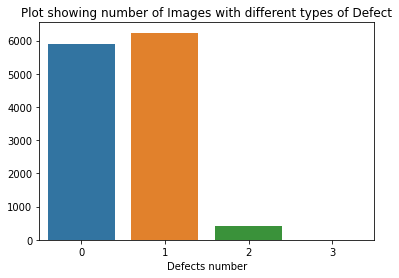

In [13]:
values_counter = list(Counter(train_df.loc[train_df.ClassId.isnull() == False, "ImageId"]).values())
values_counter = Counter(values_counter)

values_counter[0] = len(train_df.loc[train_df.ClassId.isnull(), "ImageId"])
values_counter= dict(sorted(values_counter.items(), key=lambda i: i[0]))  

fig, ax = plt.subplots()
sns.barplot(x=list(values_counter.keys()), y=list(values_counter.values()), ax=ax)
ax.set_title("Plot showing number of Images with different types of Defect")
ax.set_xlabel("Defects number")

values_counter

**Conclusion**

From the above plot it is clear that there is 5902 images without any defects and 6239 images have defect having only 1 class or defect type & very few has defects of 2 class type

Counter({1.0: 897, 2.0: 247, 3.0: 5150, 4.0: 801})

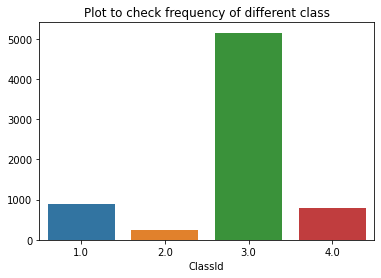

In [14]:
values_counter = Counter(train_df.loc[train_df.ClassId.isnull() == False, "ClassId"])

fig, ax = plt.subplots()
sns.barplot(x=list(values_counter.keys()), y=list(values_counter.values()), ax=ax)
ax.set_title("Plot to check frequency of different class")
ax.set_xlabel("ClassId")

values_counter

**Here, most of the images have defect class 3 and defect class 2 being the least**

In [15]:
train2 = pd.DataFrame(columns=['ImageId', 'e1', 'e2', 'e3', 'e4'])  
for row in range(len(train_df)):
    if train_df.iloc[row, 0] not in list(train2.ImageId):
        train2 = train2.append({'ImageId' : train_df.iloc[row, 0]}, ignore_index=True)
    if np.isnan(train_df.iloc[row, 1]) == False:
        train2.loc[train2['ImageId'] == train_df.iloc[row, 0], f'e{int(train_df.iloc[row, 1])}'] = train_df.iloc[row, 2]
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

,ImageId,e1,e2,e3,e4,count
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1
1,00031f466.jpg,,,,,0
2,000418bfc.jpg,,,,,0
3,000789191.jpg,,,,,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1


**Data Generator**

In [16]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(str(self.data_path + f)).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None:
            X = self.preprocess(X)
        if self.subset == 'train':
            return X, y
        else: 
            return X

**Visualizing Masks**

In [17]:

def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3)

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

 **Let's Visualize mask with few image samples**

[8487, 5679, 5097, 1683, 11921, 8971, 10352, 8155, 8795, 9118, 7665, 3811, 4492, 4090, 5677, 258]
Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


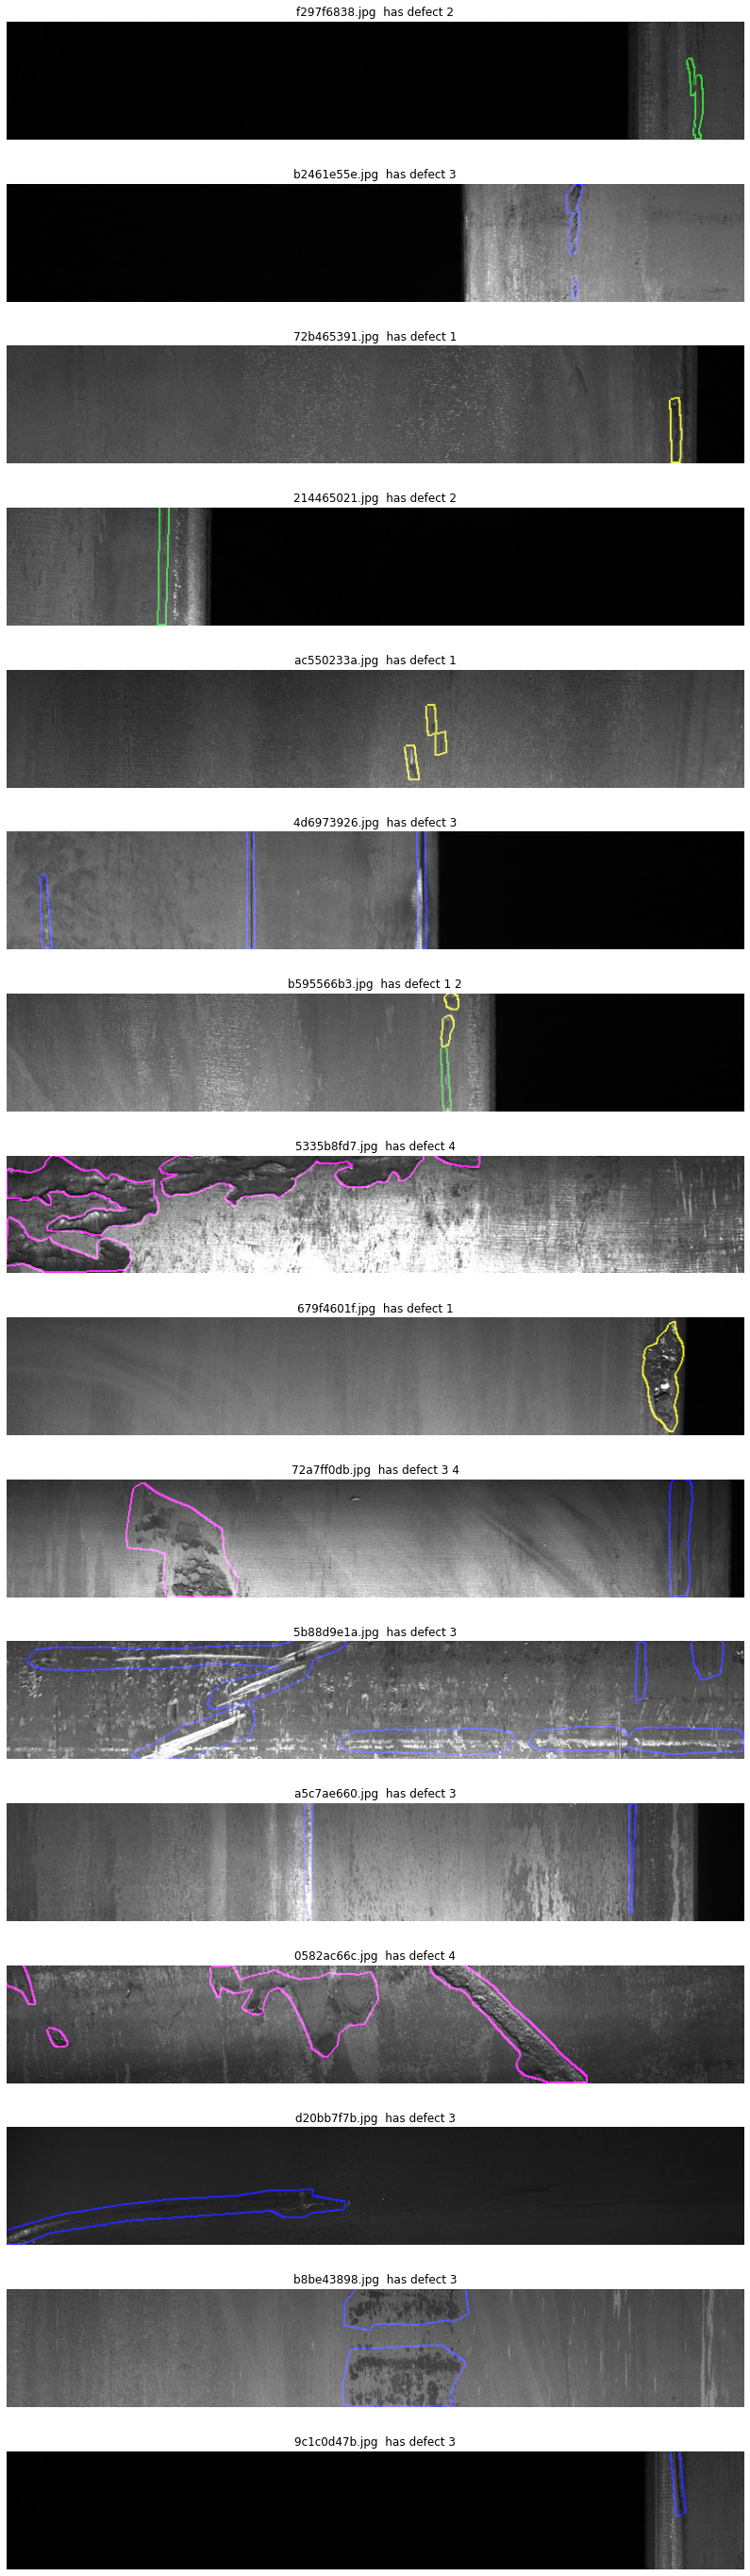

In [18]:
# DEFECTIVE IMAGE SAMPLES
path = "/content/drive/MyDrive/Dataset/"

filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)
print(defects)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50))
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [19]:
! pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.7 MB/s 


In [20]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [21]:
from keras import backend as K

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = sm.get_preprocessing('resnet34') 
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = sm.Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); print()
train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
history = model.fit(train_batches, validation_data = valid_batches, epochs = 30, verbose=1, callbacks=[callback])

Epoch 1/30

628/628 [==============================] - 1686s 3s/step - loss: 0.0470 - dice_coef: 0.1639 - val_loss: 0.0213 - val_dice_coef: 0.2825

Epoch 2/30

628/628 [==============================] - 292s 465ms/step - loss: 0.0207 - dice_coef: 0.3278 - val_loss: 0.0206 - val_dice_coef: 0.3826

Epoch 3/30

628/628 [==============================] - 291s 463ms/step - loss: 0.0183 - dice_coef: 0.3858 - val_loss: 0.0182 - val_dice_coef: 0.3880

Epoch 4/30

628/628 [==============================] - 291s 463ms/step - loss: 0.0169 - dice_coef: 0.4221 - val_loss: 0.0162 - val_dice_coef: 0.4046

Epoch 5/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0154 - dice_coef: 0.4582 - val_loss: 0.0243 - val_dice_coef: 0.3821

Epoch 6/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0153 - dice_coef: 0.4675 - val_loss: 0.0523 - val_dice_coef: 0.2798

Epoch 7/30

628/628 [==============================] - 291s 463ms/step - loss: 0.0142 - dice_coef: 0.4901 - val_loss: 0.0145 - val_dice_coef: 0.5256

Epoch 8/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0133 - dice_coef: 0.5191 - val_loss: 0.0140 - val_dice_coef: 0.5041

Epoch 9/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0127 - dice_coef: 0.5353 - val_loss: 0.0130 - val_dice_coef: 0.4887

Epoch 10/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0125 - dice_coef: 0.5412 - val_loss: 0.0136 - val_dice_coef: 0.5531

Epoch 11/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0118 - dice_coef: 0.5615 - val_loss: 0.0120 - val_dice_coef: 0.5602

Epoch 12/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0110 - dice_coef: 0.5840 - val_loss: 0.0143 - val_dice_coef: 0.5347

Epoch 13/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0103 - dice_coef: 0.6040 - val_loss: 0.0120 - val_dice_coef: 0.5952

Epoch 14/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0107 - dice_coef: 0.5992 - val_loss: 0.0128 - val_dice_coef: 0.5985

Epoch 15/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0096 - dice_coef: 0.6291 - val_loss: 0.0124 - val_dice_coef: 0.5639

Epoch 16/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0091 - dice_coef: 0.6502 - val_loss: 0.0149 - val_dice_coef: 0.5510

Epoch 17/30

628/628 [==============================] - 289s 460ms/step - loss: 0.0095 - dice_coef: 0.6326 - val_loss: 0.0157 - val_dice_coef: 0.4755

Epoch 18/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0085 - dice_coef: 0.6673 - val_loss: 0.0150 - val_dice_coef: 0.5691

Epoch 19/30

628/628 [==============================] - 289s 461ms/step - loss: 0.0078 - dice_coef: 0.6918 - val_loss: 0.0124 - val_dice_coef: 0.6261

Epoch 20/30

628/628 [==============================] - 289s 460ms/step - loss: 0.0077 - dice_coef: 0.6922 - val_loss: 0.0134 - val_dice_coef: 0.6218

Epoch 21/30

628/628 [==============================] - 289s 461ms/step - loss: 0.0079 - dice_coef: 0.6864 - val_loss: 0.0135 - val_dice_coef: 0.6274

Epoch 22/30

628/628 [==============================] - 290s 462ms/step - loss: 0.0068 - dice_coef: 0.7227 - val_loss: 0.0130 - val_dice_coef: 0.6241

Epoch 23/30

628/628 [==============================] - 289s 460ms/step - loss: 0.0077 - dice_coef: 0.6972 - val_loss: 0.0143 - val_dice_coef: 0.6031

Epoch 24/30

628/628 [==============================] - 289s 459ms/step - loss: 0.0079 - dice_coef: 0.6889 - val_loss: 0.0149 - val_dice_coef: 0.5834

Epoch 25/30

628/628 [==============================] - 289s 461ms/step - loss: 0.0064 - dice_coef: 0.7384 - val_loss: 0.0139 - val_dice_coef: 0.6159

Epoch 26/30

628/628 [==============================] - 289s 461ms/step - loss: 0.0061 - dice_coef: 0.7517 - val_loss: 0.0175 - val_dice_coef: 0.5814

Epoch 27/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0065 - dice_coef: 0.7370 - val_loss: 0.0150 - val_dice_coef: 0.6351

Epoch 28/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0054 - dice_coef: 0.7746 - val_loss: 0.0160 - val_dice_coef: 0.6163

Epoch 29/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0055 - dice_coef: 0.7740 - val_loss: 0.0145 - val_dice_coef: 0.6461

Epoch 30/30

628/628 [==============================] - 290s 461ms/step - loss: 0.0053 - dice_coef: 0.7787 - val_loss: 0.0135 - val_dice_coef: 0.6394

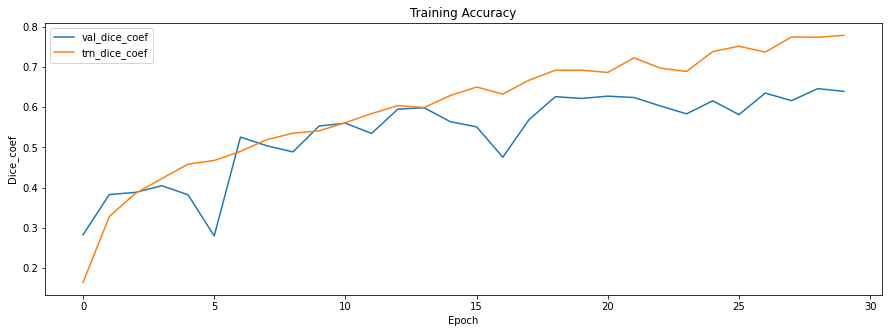

In [ ]:
 # PLOT TRAINING TO CHECK ACCURACY OF THE MODEL
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 800, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 134, 806, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [23]:
#save model for loading and deployment
model.save('/content/drive/MyDrive/Colab Notebooks/UNET.h5')
#model.save('/content/drive/MyDrive/Model_save/UNET.h5')

# LOAD MODEL
from keras.models import load_model
model = load_model('/content/drive/MyDrive/UNET.h5',custom_objects={'dice_coef':dice_coef})

In [24]:
def mask2RLE(binary_mask):
    pix_min=250
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    
    if np.sum(binary_mask,axis=(0,1)) < pix_min:
        counts.append(409600)
        return counts
    
    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return counts

**Let's Predict results from our model**

In [25]:
# PREDICT
import numpy.ma as ma

THRESHOLD=0.5
predict = pd.DataFrame(columns=['ImageId', 'EncodedPixels', 'ClassId'])
        

# PREDICT 1 BATCH TEST DATASET
test = pd.read_csv(path + 'sample_submission.csv')

for c in range(math.ceil(len(test)/256)):
    try:
        test_batches = DataGenerator(test[c*256: (c+1)*256], subset='test', batch_size=256, preprocess=preprocess)
        test_preds = model.predict_generator(test_batches,steps=1,verbose=1)
    except ValueError: # in case if dataset_size is less than batch_size 
        test_batches = DataGenerator(test[c*256:], subset='test', batch_size=len(test[c*256:]), preprocess=preprocess)
        test_preds = model.predict_generator(test_batches,steps=1,verbose=1)

    for i in range(len(test_preds)):
        test_preds2 = test_preds[i].copy()
        test_preds2[test_preds2>=THRESHOLD]=1
        test_preds2[test_preds2<THRESHOLD]=0
        for j in range(4):
            currentRLE = mask2RLE(ma.resize( test_preds2[:,:,j], ( 256, 1600)))
            if len(currentRLE) > 1:
                predict = predict.append({'ImageId'       : test.loc[c*256+i, 'ImageId'],
                                          'EncodedPixels' : ' '.join(map(str, currentRLE)),
                                          'ClassId'       : j},
                                         ignore_index=True)
predict.head()

1/1 [==============================] - 11s 11s/step


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,73275 5 59 5 59 5 59 5 12 52 12 52 12 52 12 52...,2
1,000ccc2ac.jpg,185365 3 61 3 61 3 61 3 59 5 59 5 59 5 59 5 58...,0
2,002451917.jpg,15394 29 35 29 35 29 35 29 11 10 3 41 10 10 3 ...,2
3,003c5da97.jpg,17160 1 63 1 63 1 63 1 62 3 61 3 61 3 61 3 61 ...,2
4,0042e163f.jpg,17667 3 61 3 61 3 61 3 61 3 61 3 61 3 61 3 60 ...,2


In [26]:
predict['ClassId'] = predict['ClassId'] + 1

**Finally performing test on all the test_images and inputting resultant pixels in sample_submission.csv file**

In [27]:
predict.to_csv('/content/drive/MyDrive/Dataset/sample_submission.csv', index=False)